In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
tqdm.pandas()

In [2]:
clear = pd.read_csv('clear_ready.csv')
clear['phish'] = False
clear

,tld,html_len,text_len,text_ratio,is_accessible,use_generator,use_stats,domain_age,legal_tld,free_tld,...,self_signed_ssl,no_ssl,free_host,own_ns_servers,san,notbefore,notafter,is_redirect,redirects,phish
0,com,30315,778,0.025664,True,False,False,289,True,False,...,False,False,False,True,19,True,True,True,1,False
1,ru,319645,6215,0.019443,True,False,False,252,True,False,...,False,False,False,True,2,True,True,True,2,False
2,ru,798466,69371,0.086880,True,False,False,284,True,False,...,False,False,False,True,2,True,True,False,0,False
3,ru,202511,13017,0.064278,True,False,False,286,True,False,...,False,False,False,True,56,True,True,False,0,False
4,ru,202317,12907,0.063796,True,False,False,286,True,False,...,False,False,False,True,56,True,True,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,com,26847,869,0.032369,True,False,False,286,True,False,...,False,False,False,True,73,True,True,True,2,False
246,com,814926,69049,0.084730,True,False,False,227,True,False,...,False,False,False,False,2,True,True,True,1,False
247,ca,252174,30965,0.122792,True,False,False,249,False,False,...,False,False,True,False,2,True,True,True,1,False
248,org,192311,23738,0.123435,True,False,False,316,True,False,...,False,False,False,False,2,True,True,True,1,False


In [3]:
bad = pd.read_csv('bad_ready.csv')
bad['phish'] = True
bad

,tld,html_len,text_len,text_ratio,is_accessible,use_generator,use_stats,domain_age,legal_tld,free_tld,...,self_signed_ssl,no_ssl,free_host,own_ns_servers,san,notbefore,notafter,is_redirect,redirects,phish
0,ru,25549,19651,0.769149,True,False,False,23,True,False,...,True,True,False,False,0,False,False,False,0,True
1,net,2522,2,0.000793,True,False,False,31,False,False,...,True,True,False,False,0,False,False,False,0,True
2,ru,631572,105781,0.167488,True,False,False,26,True,False,...,False,False,False,False,1,True,True,True,1,True
3,com,559510,11233,0.020076,True,False,False,187,True,False,...,False,False,False,False,2,True,True,True,2,True
4,com,146381,23400,0.159857,True,True,False,27,True,False,...,False,False,False,True,2,True,True,True,2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10568,com,10302,2813,0.273054,True,False,False,26,True,False,...,False,False,False,False,2,True,True,True,1,True
10569,co.uk,612,324,0.529412,True,False,False,194,False,False,...,False,False,False,False,2,True,True,False,0,True
10570,ru,109828,14227,0.129539,True,False,False,84,True,False,...,False,False,False,False,9,True,True,False,0,True
10571,com,27694,3115,0.112479,True,False,False,4,True,False,...,False,False,False,False,2,True,True,True,1,True


In [4]:
df = clear.copy()
df = df.append(bad.copy())
df = df.reset_index(drop=True)
df = df.drop(columns=['text_ratio', 'is_accessible', ])
df

,tld,html_len,text_len,use_generator,use_stats,domain_age,legal_tld,free_tld,has_robots,sitemap_in_robots,...,self_signed_ssl,no_ssl,free_host,own_ns_servers,san,notbefore,notafter,is_redirect,redirects,phish
0,com,30315,778,False,False,289,True,False,True,False,...,False,False,False,True,19,True,True,True,1,False
1,ru,319645,6215,False,False,252,True,False,True,False,...,False,False,False,True,2,True,True,True,2,False
2,ru,798466,69371,False,False,284,True,False,True,True,...,False,False,False,True,2,True,True,False,0,False
3,ru,202511,13017,False,False,286,True,False,True,True,...,False,False,False,True,56,True,True,False,0,False
4,ru,202317,12907,False,False,286,True,False,True,True,...,False,False,False,True,56,True,True,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,com,10302,2813,False,False,26,True,False,False,False,...,False,False,False,False,2,True,True,True,1,True
10819,co.uk,612,324,False,False,194,False,False,False,False,...,False,False,False,False,2,True,True,False,0,True
10820,ru,109828,14227,False,False,84,True,False,False,False,...,False,False,False,False,9,True,True,False,0,True
10821,com,27694,3115,False,False,4,True,False,True,False,...,False,False,False,False,2,True,True,True,1,True


In [5]:
tlds = df.tld.unique().tolist()
countries = df.country.unique().tolist()

def code_tld(x):
    for i in range(len(tlds)):
        if x == tlds[i]:
            return i
    return -1
        
def code_country(x):
    for i in range(len(countries)):
        if x == countries[i]:
            return i
    return -1

df.tld = df.tld.apply(code_tld).astype('int32')
df.country = df.country.apply(code_country).astype('int32')
df.asn_date = df.asn_date.fillna(0).astype('float32')
df.html_len = df.html_len.astype('int32')
df.text_len = df.text_len.astype('int32')
df.domain_age = df.domain_age.astype('int32')
df.number_of_pages = df.number_of_pages.astype('int32')
df.san = df.san.astype('int32')
df.redirects = df.redirects.astype('int32')

df

,tld,html_len,text_len,use_generator,use_stats,domain_age,legal_tld,free_tld,has_robots,sitemap_in_robots,...,self_signed_ssl,no_ssl,free_host,own_ns_servers,san,notbefore,notafter,is_redirect,redirects,phish
0,0,30315,778,False,False,289,True,False,True,False,...,False,False,False,True,19,True,True,True,1,False
1,1,319645,6215,False,False,252,True,False,True,False,...,False,False,False,True,2,True,True,True,2,False
2,1,798466,69371,False,False,284,True,False,True,True,...,False,False,False,True,2,True,True,False,0,False
3,1,202511,13017,False,False,286,True,False,True,True,...,False,False,False,True,56,True,True,False,0,False
4,1,202317,12907,False,False,286,True,False,True,True,...,False,False,False,True,56,True,True,True,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,0,10302,2813,False,False,26,True,False,False,False,...,False,False,False,False,2,True,True,True,1,True
10819,6,612,324,False,False,194,False,False,False,False,...,False,False,False,False,2,True,True,False,0,True
10820,1,109828,14227,False,False,84,True,False,False,False,...,False,False,False,False,9,True,True,False,0,True
10821,0,27694,3115,False,False,4,True,False,True,False,...,False,False,False,False,2,True,True,True,1,True


In [6]:
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])


df.apply(minMax).transpose()

,min,max
tld,0,370
html_len,0,4665393
text_len,0,642412
use_generator,False,True
use_stats,False,True
domain_age,1,425
legal_tld,False,True
free_tld,False,True
has_robots,False,True
sitemap_in_robots,False,True


In [7]:
df.isna().sum()

tld                  0
html_len             0
text_len             0
use_generator        0
use_stats            0
domain_age           0
legal_tld            0
free_tld             0
has_robots           0
sitemap_in_robots    0
has_sitemap          0
number_of_pages      0
personal_owner       0
country              0
asn_date             0
valid_domain         0
free_ssl             0
self_signed_ssl      0
no_ssl               0
free_host            0
own_ns_servers       0
san                  0
notbefore            0
notafter             0
is_redirect          0
redirects            0
phish                0
dtype: int64

In [8]:
df.dtypes

tld                    int32
html_len               int32
text_len               int32
use_generator           bool
use_stats               bool
domain_age             int32
legal_tld               bool
free_tld                bool
has_robots              bool
sitemap_in_robots       bool
has_sitemap             bool
number_of_pages        int32
personal_owner          bool
country                int32
asn_date             float32
valid_domain            bool
free_ssl                bool
self_signed_ssl         bool
no_ssl                  bool
free_host               bool
own_ns_servers          bool
san                    int32
notbefore               bool
notafter                bool
is_redirect             bool
redirects              int32
phish                   bool
dtype: object

In [9]:
X = df.copy()
X = X.drop(columns=['phish'])
y = df.copy().phish

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
model = XGBClassifier()
model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:28:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [12]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred)
print(f"Scores:\n\tAccuracy: {accuracy}\n\tROC_AUC:  {roc_auc}\n\tF1:       {f1}")

Scores:
	Accuracy: 0.9852171234986141
	ROC_AUC:  0.7367619449920211
	F1:       0.9924788467565027


In [13]:
for i in range(len(df.columns[:-1])):
    print(df.columns[i], model.feature_importances_[i])

tld 0.0782371
html_len 0.04069647
text_len 0.039293632
use_generator 0.050986454
use_stats 0.023348326
domain_age 0.088408716
legal_tld 0.03449708
free_tld 0.0
has_robots 0.017780598
sitemap_in_robots 0.10107166
has_sitemap 0.021988338
number_of_pages 0.029668478
personal_owner 0.0317046
country 0.066635735
asn_date 0.030884821
valid_domain 0.05779404
free_ssl 0.0
self_signed_ssl 0.0
no_ssl 0.0
free_host 0.08548097
own_ns_servers 0.037395652
san 0.080157384
notbefore 0.0
notafter 0.0
is_redirect 0.042710174
redirects 0.04125977


<Figure size 2880x1440 with 0 Axes>

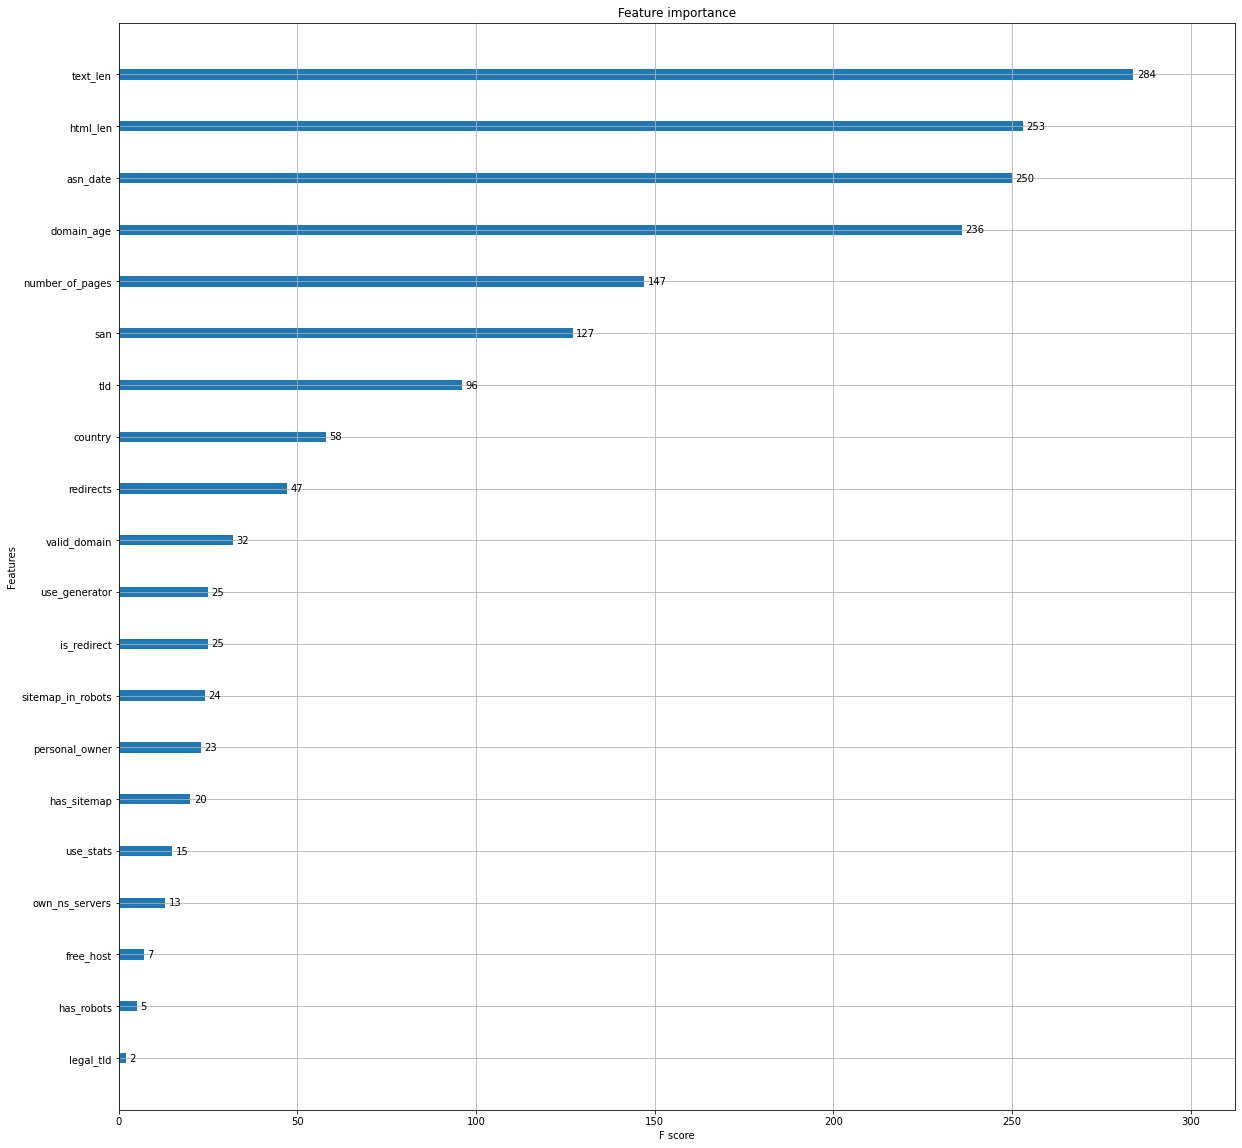

In [14]:
plt.figure(figsize=(40,20));
plt.rcParams["figure.figsize"] = (20,20);
plot_importance(model);
plt.show();

In [15]:
pickle.dump(model, open('antiphishing.pkl', 'wb'))

In [16]:
parameters = {
        'nthread':[4], 
        'booster': ['gbtree', 'gblinear', 'dart'],
        'objective':[
            'reg:logistic',
            'binary:logistic',
            'binary:logitraw',
            'count:poisson', 
            'rank:pairwise',
            'reg:tweedie',
        ],
        'learning_rate': [0.05, 0.3, 1], 
        'gamma': [0, 0.5],
        'max_depth': [6, 10],
        'min_child_weight': [1, 10],
        'lambda': [0, 0.25], 
        'alpha': [0, 0.25],
        'silent': [1],
        'n_estimators': [1000],
        'normalize_type': ['tree', 'forest'],
        'missing':[-999],
        'seed': [1337]
    }

grid_cv = GridSearchCV(
    XGBClassifier(), 
    parameters, 
    n_jobs=12, 
    cv=3, 
    scoring='roc_auc',
    verbose=2, 
    refit=True,
)
grid_cv.fit(X_train, y_train)

print(f"Results:\n\tThe best params: {grid_cv.best_params_}\n\tThe best score: {-grid_cv.best_score_}\n")

Fitting 3 folds for each of 3456 candidates, totalling 10368 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  17 tasks      | elapsed:   57.1s
[Parallel(n_jobs=12)]: Done 138 tasks      | elapsed:  6.2min
[Parallel(n_jobs=12)]: Done 341 tasks      | elapsed: 13.2min
[Parallel(n_jobs=12)]: Done 624 tasks      | elapsed: 23.9min
[Parallel(n_jobs=12)]: Done 989 tasks      | elapsed: 38.3min
[Parallel(n_jobs=12)]: Done 1434 tasks      | elapsed: 57.5min
[Parallel(n_jobs=12)]: Done 1961 tasks      | elapsed: 71.1min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed: 74.5min
[Parallel(n_jobs=12)]: Done 3257 tasks      | elapsed: 78.3min
[Parallel(n_jobs=12)]: Done 4026 tasks      | elapsed: 295.2min
[Parallel(n_jobs=12)]: Done 4877 tasks      | elapsed: 481.8min
[Parallel(n_jobs=12)]: Done 5808 tasks      | elapsed: 536.6min
[Parallel(n_jobs=12)]: Done 6821 tasks      | elapsed: 575.7min
[Parallel(n_jobs=12)]: Done 7914 tasks      | elapsed: 585.3min
[Parallel(n_jobs=12)]: Done 9089 tasks   

[16:53:12] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:541: 
Parameters: { normalize_type, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Results:
	The best params: {'alpha': 0.25, 'booster': 'gbtree', 'gamma': 0.5, 'lambda': 0.25, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'missing': -999, 'n_estimators': 1000, 'normalize_type': 'tree', 'nthread': 4, 'objective': 'reg:logistic', 'seed': 1337, 'silent': 1}
	The best score: -0.9693938139776184



In [30]:
res = pd.DataFrame(grid_cv.cv_results_)
pd.DataFrame(res.loc[res.rank_test_score == 1].params.to_dict()).transpose()

,alpha,booster,gamma,lambda,learning_rate,max_depth,min_child_weight,missing,n_estimators,normalize_type,nthread,objective,seed,silent
2160,0.25,gbtree,0.5,0.25,0.05,6,1,-999,1000,tree,4,reg:logistic,1337,1
2161,0.25,gbtree,0.5,0.25,0.05,6,1,-999,1000,tree,4,binary:logistic,1337,1
2166,0.25,gbtree,0.5,0.25,0.05,6,1,-999,1000,forest,4,reg:logistic,1337,1
2167,0.25,gbtree,0.5,0.25,0.05,6,1,-999,1000,forest,4,binary:logistic,1337,1
3312,0.25,dart,0.5,0.25,0.05,6,1,-999,1000,tree,4,reg:logistic,1337,1
3313,0.25,dart,0.5,0.25,0.05,6,1,-999,1000,tree,4,binary:logistic,1337,1
3318,0.25,dart,0.5,0.25,0.05,6,1,-999,1000,forest,4,reg:logistic,1337,1
3319,0.25,dart,0.5,0.25,0.05,6,1,-999,1000,forest,4,binary:logistic,1337,1


In [33]:
y_pred = grid_cv.best_estimator_.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred)
print(f"Scores:\n\tAccuracy: {accuracy}\n\tROC_AUC:  {roc_auc}\n\tF1:       {f1}")

Scores:
	Accuracy: 0.9846011703110563
	ROC_AUC:  0.7291420257204543
	F1:       0.992165465371357


In [19]:
pickle.dump(model, open('antiphishing_cv.pkl', 'wb'))

In [102]:
s_model = XGBClassifier(
    objective='reg:logistic', 
    n_estimators=10000, 
    max_depth=10, 
    learning_rate=0.05, 
    reg_lambda=0.75,
    gamma=0,
    alpha=0.25, 
    booster='gbtree',
    use_label_encoder=False,
)
s_model.fit(X_train, y_train)

XGBClassifier(alpha=0.25, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10000, n_jobs=8, num_parallel_tree=1,
              objective='reg:logistic', random_state=0, reg_alpha=0.25,
              reg_lambda=0.75, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [103]:
y_pred = s_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred)
print(f"Scores:\n\tAccuracy: {accuracy}\n\tROC_AUC:  {roc_auc}\n\tF1:       {f1}")

Scores:
	Accuracy: 0.9864490298737296
	ROC_AUC:  0.7520017835351543
	F1:       0.993105609526794


In [110]:
pickle.dump(s_model, open('antiphishing_best.pkl', 'wb'))

In [105]:
pickle.dump(tlds, open('tlds.pkl', 'wb'))
pickle.dump(countries, open('countries.pkl', 'wb'))

In [111]:
t = pickle.load(open('antiphishing_best.pkl', 'rb'))
y_pred = t.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
roc_auc  = roc_auc_score(y_test, y_pred)
f1       = f1_score(y_test, y_pred)
print(f"Scores:\n\tAccuracy: {accuracy}\n\tROC_AUC:  {roc_auc}\n\tF1:       {f1}")

Scores:
	Accuracy: 0.9864490298737296
	ROC_AUC:  0.7520017835351543
	F1:       0.993105609526794
